In [1]:
#load Numpy, Matplotlib, and klampt vectorops, so3, and se3 modules. Define some utilities
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from klampt.math import vectorops,so3,se3
import math
import os

def read_scan(dataset,scan):
    """Returns a scan as a tuple (T,pts) where T is a Klampt se3 element"""
    pose = None
    points = []
    with open(os.path.join(dataset,scan+".pose"),'r') as f:
        trans = [float(x) for x in f.readline().split()]
        if len(trans) != 3:
            raise IOError("Pose translation doesn't have 3 elements?")
        euler = [float(x) for x in f.readline().split()]
        if len(euler) != 3:
            raise IOError("Pose euler angles doesn't have 3 elements?")
        #euler angles are euler x, euler y, euler z in degrees
        R = so3.from_rpy([math.radians(v) for v in euler])
        pose = (R,trans)
    with open(os.path.join(dataset,scan+".3d"),'r') as f:
        for line in f.readlines():
            pt = [float(x) for x in line.split()]
            if len(pt) == 0:
                continue
            if len(pt) != 3:
                raise IOError("Point doesn't have 3 elements?")
            points.append(pt)
    #points are in left-handed coordinates, convert to right-handed
    points = np.array(points)
    points[:,2] *= -1
    return pose,points

def transform_pc(pc,T,point_channels=[0,1,2],normal_channels=[6,7,8]):
    """Given a point cloud `pc` and a transform T, apply the transform
    to the point cloud (in place).
    
    Args:
        pc (np.ndarray): an N x M numpy array, with N points and M
            channels.
        T (klampt se3 element): a Klamp't se3 element representing
            the transform to apply.
        point_channels (list of 3 ints): The channel indices (columns)
             in pc corresponding to the point data.
        normal_channels (list of 3 ints): The channels indices(columns)
            in pc corresponding to the normal data.  If this is None
            or an index is >= M, just ignore.
    """
    N,M = pc.shape
    assert len(point_channels) == 3
    for i in point_channels:
        assert i < M,"Invalid point_channel"
    #tranform the points
    for i in range(N):
        #extract a length-M array from pc
        point_data = pc[i,:]
        
        #do something to the point_data
        point = point_data[point_channels]
        point_data[point_channels] = se3.apply(T,point)
        
    if normal_channels is not None and normal_channels[0] < M:
        for i in normal_channels:
            assert i < M,"Invalid normal_channel"
        for i in range(N):
            #extract a length-M array from pc
            point_data = pc[i,:]

            #do something to the point_data
            point = point_data[normal_channels]
            point_data[normal_channels] = so3.apply(T[0],point)

def hsv2rgb(h, s, v):
    """Hue-saturation-value to RGB. Output channels are in the range [0,1]"""
    h60 = h / 60.0
    h60f = math.floor(h60)
    hi = int(h60f) % 6
    f = h60 - h60f
    p = v * (1 - s)
    q = v * (1 - f * s)
    t = v * (1 - (1 - f) * s)
    r, g, b = 0, 0, 0
    if hi == 0: r, g, b = v, t, p
    elif hi == 1: r, g, b = q, v, p
    elif hi == 2: r, g, b = p, v, t
    elif hi == 3: r, g, b = p, q, v
    elif hi == 4: r, g, b = t, p, v
    elif hi == 5: r, g, b = v, p, q
    return r, g, b
    
def rgb2hsv(r, g, b):
    """RGB to Hue-saturation-value. Input channels are in the range [0,1]"""
    mx = max(r, g, b)
    mn = min(r, g, b)
    df = mx-mn
    if mx == mn:
        h = 0
    elif mx == r:
        h = (60 * ((g-b)/df) + 360) % 360
    elif mx == g:
        h = (60 * ((b-r)/df) + 120) % 360
    elif mx == b:
        h = (60 * ((r-g)/df) + 240) % 360
    if mx == 0:
        s = 0
    else:
        s = df/mx
    v = mx
    return h, s, v

In [2]:
#Basic plane fitting utilities. You might want to learn how these work!

def fit_plane3(point1,point2,point3):
    """Returns a 3D plane equation fitting the 3 points.
    
    The result is (a,b,c,d) with the plane equation ax+by+cz+d=0
    """
    normal = np.cross(point2-point1,point3-point1)
    nlen = np.linalg.norm(normal)
    if nlen < 1e-4:
        #degenerate
        raise ValueError("Points are degenerate")
    normal = normal / nlen
    offset = -np.dot(normal,point1)
    return (normal[0],normal[1],normal[2],offset)


def fit_plane(points):
    """Returns a 3D plane equation that is a least squares fit
    through the points (len(points) >= 3)."""
    if len(points)<3:
        raise ValueError("Need to have at least 3 points to fit a plane")
    #if len(points)==3:
    #    return fit_plane3(points[0],points[1],points[2])
    centroid = np.average(points,axis=0)
    U,W,Vt = np.linalg.svd(points-[centroid]*len(points))
    normal = Vt[2,:]
    return normal[0],normal[1],normal[2],-np.dot(centroid,normal)


class PlaneFitter:
    """
    Online fitting of planes through 3D point clouds
    
    Attributes:
        normal (3-vector): best-fit normal
        centroid (3-vector): centroid of points
        count (int): # of points
        sse (float): fitting sum of squared errors
        cov (3x3 array): covariance of points
    """
    def __init__(self,points=None):
        if points is None:
            self.count = 0
            self.centroid = np.zeros(3)
            self.cov = np.zeros((3,3))
            self.normal = np.array([0,0,1])
            self.sse = 0
        else:
            self.count = len(points)
            self.centroid = np.average(points,axis=0)
            pprime = points - [self.centroid]*len(points)
            self.cov = np.dot(pprime.T,pprime)/self.count
            self._update_plane()
    
    def plane_equation(self):
        """Returns (a,b,c,d) with ax+by+cz+d=0 the plane equation"""
        offset = np.dot(self.centroid,self.normal)
        return (self.normal[0],self.normal[1],self.normal[2],-offset)
    
    def goodness_of_fit(self):
        """Returns corrected RMSE"""
        if self.count <= 3:
            return float('inf')
        return math.sqrt(self.sse*self.count / (self.count-3))
    
    def add_point(self,pt):
        """Online estimation of best fit plane"""
        new_count = self.count + 1
        new_centroid = self.centroid + (pt-self.centroid)/new_count
        old_sse = (self.cov + np.outer(self.centroid,self.centroid))*self.count
        new_sse = old_sse + np.outer(pt,pt)
        new_cov = new_sse/new_count - np.outer(new_centroid,new_centroid)
        self.count = new_count
        self.centroid = new_centroid
        self.cov = new_cov
        self._update_plane()
    
    def merge(self,fitter,inplace = False):
        """Online merging of two plane fitters. 
        
        If inplace = False, returns a new PlaneFitter.
        If inplace = True, self is updated with the result.
        """
        if not inplace:
            res = PlaneFitter()
        else:
            res = self
        new_count = self.count + fitter.count
        old_sum = self.centroid*self.count
        new_sum = old_sum + fitter.centroid*fitter.count
        new_centroid = new_sum/new_count
        old_sse = (self.cov + np.outer(self.centroid,self.centroid))*self.count
        fitter_sse = (fitter.cov + np.outer(fitter.centroid,fitter.centroid))*fitter.count
        new_sse = old_sse + fitter_sse
        new_cov = new_sse/new_count - np.outer(new_centroid,new_centroid)
        res.count = new_count
        res.centroid = new_centroid
        res.cov = new_cov
        res._update_plane()
        return res
    
    def distance(self,pt):
        """Returns the signed distance to this plane"""
        return np.dot(self.normal,pt)-np.dot(self.normal,self.centroid)

    def _update_plane(self):
        w,v = np.linalg.eig(self.cov)
        index = np.argmin(w)
        self.normal = v[:,index]
        self.sse = self.count * np.dot(self.normal,np.dot(self.cov,self.normal))

#these should all be the same up to a sign change
print("Testing Plane-fitting routines")
points = np.array([[0.5,0.0,9],[1,1,10],[-1,-1,10]])
print(fit_plane3(points[0],points[1],points[2]))
print(fit_plane(points))
print(PlaneFitter(points).plane_equation())
fitter = PlaneFitter()
fitter.add_point(points[0])
fitter.add_point(points[1])
fitter.add_point(points[2])
print(fitter.plane_equation())

Testing Plane-fitting routines
(0.6666666666666666, -0.6666666666666666, 0.3333333333333333, -3.3333333333333335)
(0.6666666666666666, -0.6666666666666669, 0.33333333333333354, -3.3333333333333353)
(0.6666666666666665, -0.6666666666666666, 0.3333333333333336, -3.3333333333333357)
(0.666666666666672, -0.6666666666666743, 0.3333333333333078, -3.333333333333087)


In [3]:
#Run me to read in a scan from the dataset

DATASET = "hannover1/"
SCAN = "scan013"

T,pts = read_scan(DATASET,SCAN)
flipyz = so3.rotation((1,0,0),math.pi/2)
transform_pc(pts,(flipyz,[0,0,0]))
#transform_pc(pts,T)

In [4]:
#Run me to generate a two-plane dataset by random sampling
fake_wall_pts = []
for i in range(4000):
    fake_wall_pts.append([np.random.uniform(500,1500),np.random.uniform(-500,500),100])
for i in range(1000):
    fake_wall_pts.append([500,np.random.uniform(-500,500),np.random.uniform(100,1000)])
fake_wall_pts = np.array(fake_wall_pts)
R = np.array(so3.matrix(so3.rotation((0,0,1),math.radians(30))))
fake_wall_pts = fake_wall_pts.dot(R)

#uncomment me to test on the plane dataset
#pts = fake_wall_pts

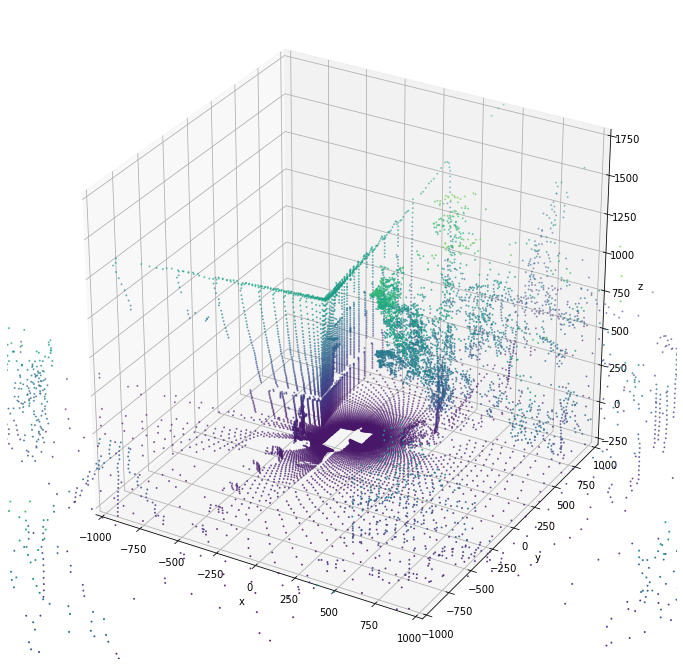

***  klampt.vis: using Qt5 as the visualization backend  ***


KlamptWidget(scene={'metadata': {'version': 4.4, 'type': 'Object', 'fullscene': True, 'generator': 'Klampt thr…

In [5]:
#Show matplotlib plot and Klampt visualization

fig = plt.figure(figsize=(12,12))
ax = plt.axes(projection='3d')
ax.scatter(pts[:,0],pts[:,1],pts[:,2],s=1,c=pts[:,2])
#ax.view_init(elev=90, azim=0)
ax.set_xlim(-1000,1000)
ax.set_ylim(-1000,1000)
ax.set_zlim(-250,1750)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
plt.show()

#Start the Klamp't visualization
from klampt import WorldModel
from klampt.vis.ipython import KlamptWidget
world = WorldModel()
kvis = KlamptWidget(world)
display(kvis)

In [6]:
#Run me to visualize the points that you're currently looking at
def add_pc_to_vis(kvis,pc,clear=True,color='z',subsample=None,name_prefix='p'):
    if clear:
        kvis.clearExtras()
    if subsample is not None:
        if not isinstance(color,str) and hasattr(color,'__iter__'):
            assert len(color) == len(pc)
            color = [color[v] for v in range(0,len(pc),subsample)]
        pc = pc[range(0,len(pc),subsample)]
    colors = []
    colorval = None
    if color=='z':
        colorval= pc[:,2]
    elif color=='x':
        colorval= pc[:,0]
    elif color=='y':
        colorval= pc[:,1]
    elif not isinstance(color,str) and hasattr(color,'__iter__'):
        assert len(color) == len(pc)
        if hasattr(color[0],'__iter__'):
            colors = color
        else:
            colors = [color]*len(pc)
    else:
        raise ValueError("Can't handle color value "+str(color))
    if colorval is not None:
        vmax = np.max(colorval)
        vmin = np.min(colorval)
        if vmin == vmax:
            colors = np.ones((len(pc)),3)
        else:
            inv_denom = 1.0/(vmax-vmin)
            colorval = (colorval-vmin)*inv_denom
            colors = np.array([hsv2rgb(v*240,1,1) for v in colorval])
            #colors = np.column_stack((colorval,colorval,colorval))
    print("Adding",pc.shape[0],"points to visualization")
    kvis.beginRpc()
    for i in range(pc.shape[0]):
        x,y,z = pc[i]
        name = name_prefix+str(i)
        kvis.addSphere(name,x,y,z,r=0.01)
        kvis.setColor(name,*colors[i])
    kvis.endRpc()

add_pc_to_vis(kvis,pts*0.001,subsample=9)

Adding 1758 points to visualization


In [7]:
#Various plane-fitting plotting subroutines
def plot_fitter(kvis,fitter,name,color=None):
    centroid = fitter.centroid
    v,w = np.linalg.eig(fitter.cov)
    #R = so3.canonical(fitter.normal)
    #x = so3.apply(R,[0,1,0])
    #y = so3.apply(R,[0,0,1])
    nindex = np.argmin(v)
    xaxis = (nindex + 1)%3
    yaxis = (nindex + 2)%3
    x = w[:,xaxis]
    y = w[:,yaxis]
    xvar = np.dot(x,np.dot(fitter.cov,x))
    yvar = np.dot(y,np.dot(fitter.cov,y))
    width = math.sqrt(xvar)*2
    height = math.sqrt(yvar)*2
    x=np.array(x)*width
    y=np.array(y)*height
    a = centroid-x-y
    b = centroid+x-y
    c = centroid+x+y
    d = centroid-x+y
    kvis.addQuad(name,list(a),list(b),list(c),list(d))
    kvis.addQuad(name+'b',list(d),list(c),list(b),list(a))
    if color is not None:
        kvis.setColor(name,*color)
        kvis.setColor(name+'b',*color)

def plot_fitters(kvis,fitters,clear=True,name_prefix="pl",colors=None):
    if clear:
        kvis.clearExtras()
    if colors is None:
        colors = [(1,0,0),(0,1,0),(0,0,1),(1,1,0),(1,0,1),(1,0,1)]
    items = []
    kvis.beginRpc()
    for i in range(len(fitters)):
        if i < len(colors):
            color = colors[i]
        else:
            color = np.random.uniform(size=3)
        items.append(name_prefix+str(i))
        plot_fitter(kvis,fitters[i],items[-1],color)
    kvis.endRpc()
    return items

In [14]:
#Problem A and B. This is the main event!

from collections import defaultdict

def fit_planes_ransac(pts,ntries,inlier_threshold=0.05,inlier_count=10):
    """Returns a list of PlaneFitters that may fit the given point cloud, and
    which points are assigned to which fitters.
    
    The return value is a pair (planes,assignments) where 
    assignments is a list of len(pts) integers, giving the index of the plane
    in `planes` to which a point is assigned.  `assignments[i]` should be -1 if
    no plane is assigned to point `i`.
    
    Arguments:
        pts (ndarray): a point cloud (N x 3 array)
        ntries (int): the number of RANSAC iterations to run
        inlier_threshold (float): defines the threshold for considering
            points to be inliers.
        inlier_count (int): defines the # of inliers needed for a random
            plane to be considered an inlier plane
    
    TODO: Problem A: find a way to avoid sampling more than 1 plane per flat
    surface, and to properly assign the points to the planes.
    """
    planes = []
    point_assignments = np.array([-1]*len(pts))
    point_indices = range(len(pts))
    for tries in range(ntries):
        #this samples 3 random points from point_indices, without replacement
        subset = np.random.choice(point_indices,3,replace=False)
        try:
            plane = fit_plane3(pts[subset[0]],pts[subset[1]],pts[subset[2]])
        except ValueError:
            #some error could have happened, e.g., the points were colinear
            continue
        inliers = []
        for i in point_indices:
            if point_assignments[i] >= 0: continue
            pt = pts[i]
            err = np.dot(pt,plane[:3])+plane[3]
            if abs(err) < inlier_threshold:
                inliers.append(i)
        if len(inliers)-3 >= inlier_count:
            point_assignments[inliers] = len(planes)
            planes.append(PlaneFitter(pts[inliers]))
    return planes,point_assignments


def pts_to_grid(pts,res):
    """Returns a dict mapping grid cells to point-cloud indices.
    
    Return value is of type
    
        dict[3-tuple] -> list of ints
        
    where each int is an index into the pts array.
    """
    grid = defaultdict(list)
    invres = 1.0/res
    inds = np.floor(pts[:,:3]*invres).astype(int)
    for i in range(pts.shape[0]):
        ind = tuple(inds[i])
        grid[ind].append(i)
    return grid


def plane_distance(fitter1,fitter2):
    """Returns a distance metric between two planes.  May wish to play around with
    this to get a better fitting."""
    return max(abs(fitter1.distance(fitter2.centroid)),abs(fitter2.distance(fitter1.centroid)))


def fit_planes_grid(pts,grid_res,inlier_threshold,inlier_count=10):
    """Converts points to a grid and performs ransac fitting on each grid cell.
    """
    grid = pts_to_grid(pts,grid_res)
    print(len(grid),"grid cells occupied")
    output_planes = []
    pt_to_plane = np.full(len(pts),-1)   #maps points to planes, or -1 if no plane is associated
    cell_to_planes = dict()   #maps grid cells to plane indices (will be helpful later)
    plane_to_cells = []       #maps planes to lists of grid cells (will be helpful later)
    for (cell,indices) in grid.items():
        subset = pts[indices]
        #select some number of RANSAC iterations
        if len(indices) < inlier_count+3:
            continue
        if len(indices) < inlier_count*2:
            niters = 10
        elif len(indices) < inlier_count*4:
            niters = 20
        else:
            niters = 40
        #Use RANSAC to get a set of planes fitting this cell
        gridplanes,pt_assignments = fit_planes_ransac(subset,niters,inlier_threshold,inlier_count)
        plane_index_start = len(output_planes)
        output_planes += gridplanes
        
        #Do some bookeeping to keep track of cell assignments
        plane_ids = []
        for plane_id,p in enumerate(gridplanes):
            plane_ids.append(plane_index_start + plane_id)
            plane_to_cells.append([cell])
        cell_to_planes[cell] = plane_ids
        
        #Do some bookkeeping to keep track of point assignments for the full point cloud
        for pt,plane_id in zip(indices,pt_assignments):
            if plane_id >= 0:
                assert pt_to_plane[pt] == -1
                pt_to_plane[pt] = plane_index_start+plane_id
            else:
                pt_to_plane[pt] = -1
    assert len(plane_to_cells) == len(output_planes)
                
    #TODO: Problem B: comment out this line, and pass down to the below code to do region growing
    return output_planes,pt_to_plane

    #**** REGION GROWING: ****
    #In the marked area of the code below, you will update the output_planes and pts_to_plane data
    #structures.
    
    cell_deltas = [(0,0,0),(1,0,0),(-1,0,0),(0,1,0),(0,-1,0),(0,0,1),(0,0,-1)]
    #Do some bookkeeping
    plane_to_pts = [[] for p in output_planes]
    for pt,plane in enumerate(pt_to_plane):
        if plane >= 0:
            plane_to_pts[plane].append(pt)
    
    #Declare some helper functions
    def neighbors(cell):
        #iterates over occupied neighbors of a given cell
        for delta in cell_deltas:
            neighbor = tuple(vectorops.add(cell,delta))
            if neighbor in grid:
                yield neighbor
        return
            
    def merge_planes(i,j):
        #merges plane index j into plane index i, doing all the bookkeeping needed to maintain
        #the plane_to_cell/cell_to_planes/pt_to_plane/plane_to_pts data structures. 
        #output_plane[j] is discarded.
        output_planes[i].merge(output_planes[j],inplace=True)
        output_planes[j] = None
        plane_to_cells[i] += plane_to_cells[j]
        for cell in plane_to_cells[j]:
            cell_to_planes[cell].remove(j)
        plane_to_cells[j] = []
        for pt in plane_to_pts[j]:
            pt_to_plane[pt] = pindex
        plane_to_pts[i] += plane_to_pts[j]
        plane_to_pts[j] = []
        
    #TODO: PUT YOUR CODE HERE
    #SEMANTICS:
    #- Call merge_planes(i,j) to merge plane j into plane i
    #- You should use the cell_to_planes, plane_to_cells, pt_to_plane, and plane_to_pts data structures
    #  to identify good planes to try to merge with
    #- Don't mess with the structures, outside of `merge_planes` calls (i.e., treat them as read-only)
    #
    #In problem C, you can (and should) modify the pt_to_plane data structure
    
    #The following code debugs and remaps the results of region growing
    for i,iplane in enumerate(pt_to_plane):
        if iplane >= 0 and output_planes[iplane] is None:
            raise ValueError("Invalid maintenance of point-to-plane indexing data structure, point %s has invalid plane %s"%(i,iplane))
            
    plane_collapse_map = dict()
    collapse_output_planes = []
    for i,p in enumerate(output_planes):
        if p is not None:
            plane_collapse_map[i] = len(collapse_output_planes)
            collapse_output_planes.append(p)
        else:
            plane_collapse_map[i] = None
    plane_collapse_map[-1] = -1
    
    print("Merged from",len(output_planes),"to",len(collapse_output_planes),"planes")
    for i in range(len(pt_to_plane)):
        pt_to_plane[i] = plane_collapse_map[pt_to_plane[i]]
        assert pt_to_plane[i] is not None
    return collapse_output_planes,pt_to_plane

    #**** END OF REGION GROWING ****



In [12]:
NUM_POINTS_TO_DRAW = 2000

def debug_plane_fitting(method,pts,*args,**kwargs):
    if method=='ransac':
        planes,assignments = fit_planes_ransac(pts,*args,**kwargs)
    elif method=='grid':
        planes,assignments = fit_planes_grid(pts,*args,**kwargs)
    else:
        raise ValueError("Can only accept ransac or grid fitting")
    print("Found",len(planes),"planes to fit")
    plane_colors = [np.random.uniform(size=3) for i in range(np.max(assignments)+1)]
    colors = []
    for i in range(len(pts)):
        if assignments[i] < 0:
            colors.append((0,0,0))
        else:
            colors.append(plane_colors[assignments[i]])
    add_pc_to_vis(kvis,pts,subsample=int(math.floor(len(pts)/NUM_POINTS_TO_DRAW)),color=colors)
    kvis_planes = plot_fitters(kvis,planes,clear=False,colors=plane_colors)

In [13]:
debug_plane_fitting('ransac',fake_wall_pts*0.001,ntries=100,inlier_threshold=0.005,inlier_count=100)
#Uncomment to show on Hannover point cloud
#debug_plane_fitting('grid',pts*0.001,0.1,inlier_threshold=0.005,inlier_count=10)
#Uncomment to show on fake wall point cloud
#debug_plane_fitting('grid',fake_wall_pts*0.001,0.1,inlier_threshold=0.005,inlier_count=10)

Found 63 planes to fit
Adding 2500 points to visualization
